In [60]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

In [61]:
#repo=pd.read_csv('CommitData/C_0voice_campus_recruitmen_questions.csv', sep=",")

repo=pd.read_csv('Data/ml_data/graph_data.csv', sep=",",index_col=0)
#repo=pd.read_csv('data/CommitData/C_google_WebFundamentals.csv', sep=",")
#repo=pd.read_csv('data/CommitData/C_facebook_react.csv', sep=",")


In [62]:
repo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1764 entries, 0 to 1763
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   owner           1764 non-null   object 
 1   repo            1764 non-null   object 
 2   stars           1764 non-null   int64  
 3   dateCreated     1764 non-null   int64  
 4   datePushed      1764 non-null   int64  
 5   numCommits      1764 non-null   int64  
 6   openIssues      1764 non-null   int64  
 7   closedIssues    1764 non-null   int64  
 8   totalIssues     1764 non-null   int64  
 9   totalAdditions  1764 non-null   float64
 10  totalDeletions  1764 non-null   float64
 11  fileCount       1764 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 179.2+ KB


### Data Cleaning


In [63]:
# Calculate the ratio of openIssues to closedIssues + 1 (to avoid division by zero)
repo['issue_ratio'] = repo['openIssues'] / (repo['closedIssues'] + 1)


In [64]:
repo.head()

,owner,repo,stars,dateCreated,datePushed,numCommits,openIssues,closedIssues,totalIssues,totalAdditions,totalDeletions,fileCount,issue_ratio
0,Alexander-MacDonald,test-repo,0,1696278312,1699386537,9,2,2,4,38.0,2.0,100005,0.666667
1,facebook,react,216019,1369412154,1701996680,16117,1557,25219,26776,2734078.0,1632422.0,2592,0.061737
2,pallets,flask,65156,1270552319,1701920931,5205,3,5081,5084,229166.0,162846.0,250,0.000590
3,google,guetzli,12840,1477062798,1682192470,145,121,153,274,30443.0,8464.0,86,0.785714
4,EbookFoundation,free-programming-books,304317,1381474237,1701800216,9110,43,10783,10826,87660.0,45151.0,215,0.003987


In [65]:
import pandas as pd
from datetime import datetime


repo['dateCreated'] = pd.to_datetime(repo['dateCreated'], unit='s')
repo['datePushed'] = pd.to_datetime(repo['datePushed'], unit='s')

# Normalize the stars count
repo['normalized_stars'] = repo['stars'] / repo['stars'].max()

# Commit Activity Score (scaled number of commits)
repo['commit_activity'] = repo['numCommits'] / repo['numCommits'].max()

# Recency of last push (days since last push)
current_time = datetime.now()
repo['days_since_last_push'] = (current_time - repo['datePushed']).dt.days
repo['recency_score'] = 1 / (1 + repo['days_since_last_push'])  # Inverse to make recent activity have a higher score


repo['issue_resolution_ratio'] = repo['closedIssues'] / repo['totalIssues']

alpha = 0.3  # normalized stars
beta = 0.3   #  commit activity
gamma = 0.2  #  issue resolution ratio
zeta = 0.2 #  maintenance_status_score

repo['health_score'] = (alpha * repo['normalized_stars'] +
                        beta * repo['commit_activity'] +
                        gamma * repo['issue_resolution_ratio'] +
                        zeta * repo['maintenance_status_score']
                        )

 
print(repo[['owner', 'repo', 'health_score']])


                    owner                        repo  health_score
0     Alexander-MacDonald                   test-repo      0.100168
1                facebook                       react      0.701325
2                 pallets                       flask      0.360999
3                  google                     guetzli      0.127036
4         EbookFoundation      free-programming-books      0.668778
...                   ...                         ...           ...
1759               wu9007              qrcode_scanner      0.068089
1760     qiskit-community                qiskit-metal      0.229202
1761            fanshisha                       qtalk           NaN
1762                 Esri  arcgis-maps-sdk-samples-qt      0.268081
1763              jack416                      qucsdk           NaN

[1764 rows x 3 columns]


In [66]:
def classify_repository(health_score):
    if health_score > 0.4:  
        return "Active"
    elif 0.25 < health_score <= 0.4: 
        return "At Risk"
    else:
        return "Dying"  

# Apply the function to the 'health_score' column to create a new 'status' column
repo['status'] = repo['health_score'].apply(classify_repository)
 
print(repo[['owner', 'repo', 'health_score', 'status']].head())


                 owner                    repo  health_score   status
0  Alexander-MacDonald               test-repo      0.100168    Dying
1             facebook                   react      0.701325   Active
2              pallets                   flask      0.360999  At Risk
3               google                 guetzli      0.127036    Dying
4      EbookFoundation  free-programming-books      0.668778   Active


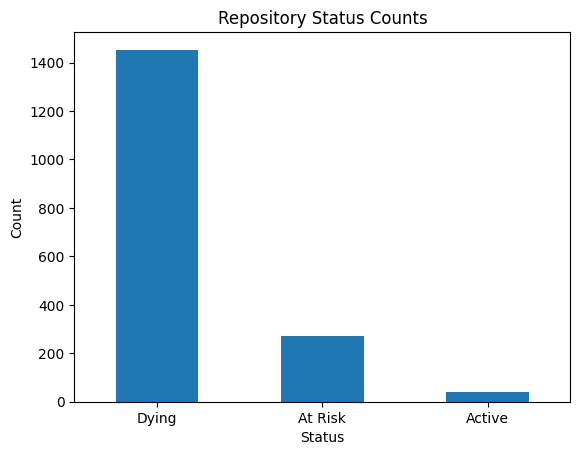

In [67]:
import matplotlib.pyplot as plt
 
status_counts = repo['status'].value_counts()
status_counts.plot(kind='bar')

 
plt.title('Repository Status Counts')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=0)   
 
plt.show()

In [68]:

active_repos = repo[repo['status'] == "Active"]

active_repos[['owner', 'repo']]

,owner,repo
1,facebook,react
4,EbookFoundation,free-programming-books
7,sindresorhus,awesome
8,vuejs,vue
9,angular,angular.js
10,robbyrussell,oh-my-zsh
14,jwasham,coding-interview-university
20,laravel,laravel
28,jekyll,jekyll
40,lodash,lodash


In [69]:
repo.head()

,owner,repo,stars,dateCreated,datePushed,numCommits,openIssues,closedIssues,totalIssues,totalAdditions,totalDeletions,fileCount,issue_ratio,normalized_stars,commit_activity,days_since_last_push,recency_score,issue_resolution_ratio,health_score,status
0,Alexander-MacDonald,test-repo,0,2023-10-02 20:25:12,2023-11-07 19:48:57,9,2,2,4,38.0,2.0,100005,0.666667,0.000000,0.000558,90,0.010989,0.500000,0.100168,Dying
1,facebook,react,216019,2013-05-24 16:15:54,2023-12-08 00:51:20,16117,1557,25219,26776,2734078.0,1632422.0,2592,0.061737,0.709849,1.000000,60,0.016393,0.941851,0.701325,Active
2,pallets,flask,65156,2010-04-06 11:11:59,2023-12-07 03:48:51,5205,3,5081,5084,229166.0,162846.0,250,0.000590,0.214106,0.322951,61,0.016129,0.999410,0.360999,At Risk
3,google,guetzli,12840,2016-10-21 15:13:18,2023-04-22 19:41:10,145,121,153,274,30443.0,8464.0,86,0.785714,0.042193,0.008997,289,0.003448,0.558394,0.127036,Dying
4,EbookFoundation,free-programming-books,304317,2013-10-11 06:50:37,2023-12-05 18:16:56,9110,43,10783,10826,87660.0,45151.0,215,0.003987,1.000000,0.565242,62,0.015873,0.996028,0.668778,Active


In [70]:
repo = repo.dropna()

In [71]:
repo.isnull().sum()

owner                     0
repo                      0
stars                     0
dateCreated               0
datePushed                0
numCommits                0
openIssues                0
closedIssues              0
totalIssues               0
totalAdditions            0
totalDeletions            0
fileCount                 0
issue_ratio               0
normalized_stars          0
commit_activity           0
days_since_last_push      0
recency_score             0
issue_resolution_ratio    0
health_score              0
status                    0
dtype: int64

In [72]:
repo.to_csv('Data/ml_data/graph_data_pb_main.csv', index=False)

In [11]:
repo.head()

,month,url,repo,author,date,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple,code_churn,monthly_commits,monthly_unique_authors,monthly_additions,monthly_deletions,time_between_commits
0,2016-03,https://api.github.com/repos/alibaba/weex/comm...,weex,lvscar,2016-03-11 10:18:12+00:00,203,0,203,Initial commit,2,0,"[('LICENSE', 'added', 201, 0, 201, 'https://gi...",203,1,1,203,0,0.000000
1,2016-04,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 15:21:18+00:00,617,8351,-7734,+ [all] init,1046,0,"[('CONTRIBUTING.md', 'modified', 0, 0, 0, 'htt...",8968,364,15,434399,88352,773.051667
2,2016-04,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 15:21:18+00:00,142902,5,142897,+ [all] init,1054,1,"[('.gitignore', 'added', 23, 0, 23, 'https://g...",142907,364,15,434399,88352,0.000000
3,2016-04,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 15:22:31+00:00,30,6,24,+ [doc] contributing doc,2,0,"[('CONTRIBUTING.md', 'added', 28, 0, 28, 'http...",36,364,15,434399,88352,0.020278
4,2016-04,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 16:00:06+00:00,32,16,16,* [doc] commit & branch format,2,0,"[('CONTRIBUTING.md', 'modified', 31, 11, 42, '...",48,364,15,434399,88352,0.626389


In [6]:
repo.nunique()

url                                                                                   12044
sha                                                                                   12044
owner                                                                                     1
repo                                                                                      1
author                                                                                  195
date                                                                                  11732
totalAdditions                                                                         1314
totalDeletions                                                                          951
message                                                                               10201
numFiles                                                                                380
numComments                                                                     

#### Code freq

In [28]:
repo.head()

,url,repo,author,date,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple
11328,https://api.github.com/repos/google/WebFundame...,WebFundamentals,PaulKinlan,2014-03-06T15:42:44Z,314,0,314,First commit of new site,8,0,"[('.gitignore', 'added', 1, 0, 1, 'https://git..."
11327,https://api.github.com/repos/google/WebFundame...,WebFundamentals,PaulKinlan,2014-03-21T14:32:16Z,15281,313,14968,Adding a port of dartlang infrastrcuture,110,0,"[('_config.yml', 'removed', 0, 3, 3, 'https://..."
11326,https://api.github.com/repos/google/WebFundame...,WebFundamentals,PaulKinlan,2014-03-21T14:41:44Z,32,10,22,Adding a make file,3,0,"[('.gitignore', 'modified', 1, 1, 2, 'https://..."
11325,https://api.github.com/repos/google/WebFundame...,WebFundamentals,PaulKinlan,2014-03-21T15:08:54Z,97,107,-10,Adding more stuff and checking build process,9,0,"[('src/site/_includes/author.html', 'removed',..."
11324,https://api.github.com/repos/google/WebFundame...,WebFundamentals,PaulKinlan,2014-03-21T19:08:06Z,208,88,120,Adding articles as samples. Updating the arti...,15,0,"[('src/site/_plugins/articles_tag.rb', 'modifi..."


In [29]:
commit_data = repo

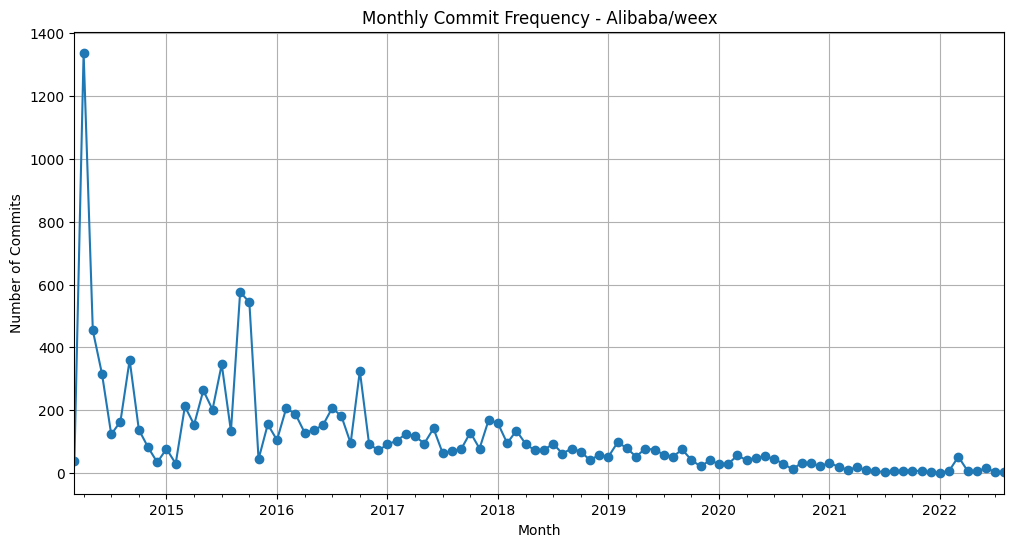

date
2022-04-30 00:00:00+00:00     7
2022-05-31 00:00:00+00:00     5
2022-06-30 00:00:00+00:00    16
2022-07-31 00:00:00+00:00     3
2022-08-31 00:00:00+00:00     2
Freq: M, dtype: int64

In [30]:
import matplotlib.pyplot as plt
 
repo['date'] = pd.to_datetime(repo['date'])

# Resample by month and count the number of commits
monthly_commits = repo.resample('M', on='date').size()

 
plt.figure(figsize=(12, 6))
monthly_commits.plot(kind='line', marker='o')
plt.title('Monthly Commit Frequency - Alibaba/weex')
plt.xlabel('Month')
plt.ylabel('Number of Commits')
plt.grid(True)
plt.show()

monthly_commits.tail()


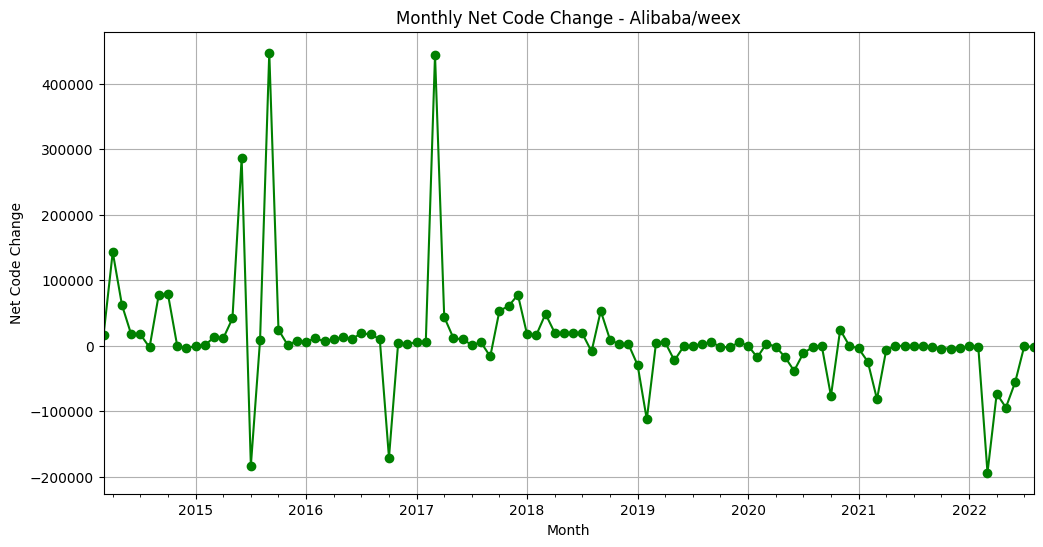

date
2022-04-30 00:00:00+00:00   -73064
2022-05-31 00:00:00+00:00   -94135
2022-06-30 00:00:00+00:00   -55769
2022-07-31 00:00:00+00:00     -192
2022-08-31 00:00:00+00:00    -2072
Freq: M, Name: net_code_change, dtype: int64

In [31]:
import matplotlib.pyplot as plt

# Resample by month and sum the total additions
monthly_additions = repo.resample('M', on='date')['net_code_change'].sum()

 
plt.figure(figsize=(12, 6))
monthly_additions.plot(kind='line', marker='o', color='green')
plt.title('Monthly Net Code Change - Alibaba/weex')
plt.xlabel('Month')
plt.ylabel('Net Code Change')
plt.grid(True)
plt.show()

monthly_additions.tail()


##### author contribution

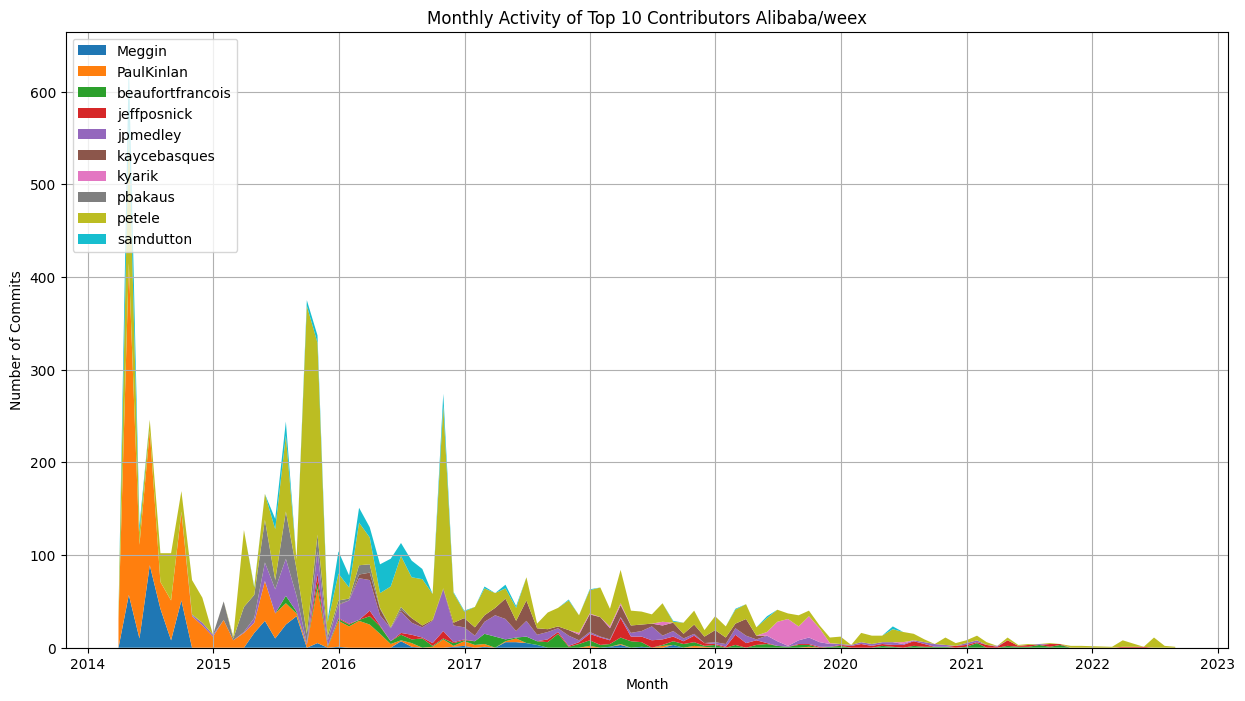

author,Meggin,PaulKinlan,beaufortfrancois,jeffposnick,jpmedley,kaycebasques,kyarik,pbakaus,petele,samdutton
date,,,,,,,,,,
2022-03-31 00:00:00+00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0
2022-05-31 00:00:00+00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-30 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0
2022-07-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2022-08-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
import matplotlib.pyplot as plt

 
top_authors = repo['author'].value_counts().nlargest(10).index

# Filtering the data to include only commits from these top authors
top_authors_data = repo[repo['author'].isin(top_authors)]

# Grouping data by author and resampling by month
top_authors_monthly_commits = top_authors_data.groupby(['author', pd.Grouper(freq='M', key='date')]).size().reset_index(name='num_commits')

 
top_pivot_table = top_authors_monthly_commits.pivot(index='date', columns='author', values='num_commits').fillna(0)

 
plt.figure(figsize=(15, 8))
plt.stackplot(top_pivot_table.index, top_pivot_table.values.T, labels=top_pivot_table.columns)
plt.title('Monthly Activity of Top 10 Contributors Alibaba/weex')
plt.xlabel('Month')
plt.ylabel('Number of Commits')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

top_pivot_table.tail()


#### commit Time difference 

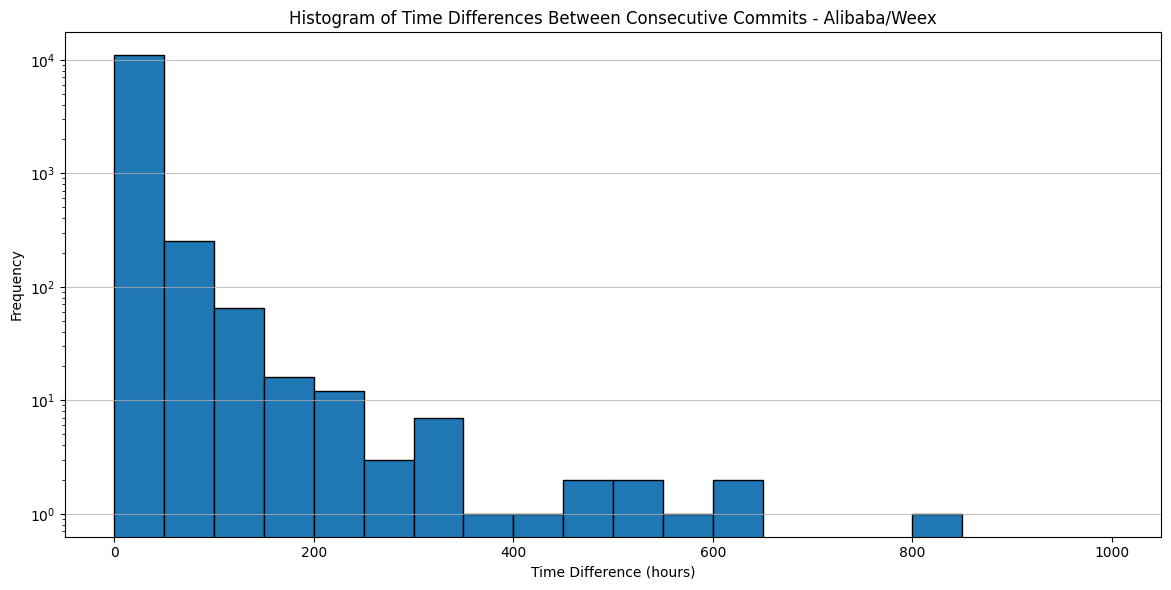

In [33]:
repo['time_diff'] = repo['date'].diff()
repo['time_diff'] = repo['time_diff'].fillna(pd.to_timedelta(0))
repo['time_diff_hours'] = repo['time_diff'].dt.total_seconds() / 3600

 
plt.figure(figsize=(12, 6))
plt.hist(repo['time_diff_hours'], bins=20, edgecolor='black', range=(0, 1000))  
plt.title('Histogram of Time Differences Between Consecutive Commits - Alibaba/Weex')
plt.xlabel('Time Difference (hours)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()

plt.yscale('log')

plt.show()

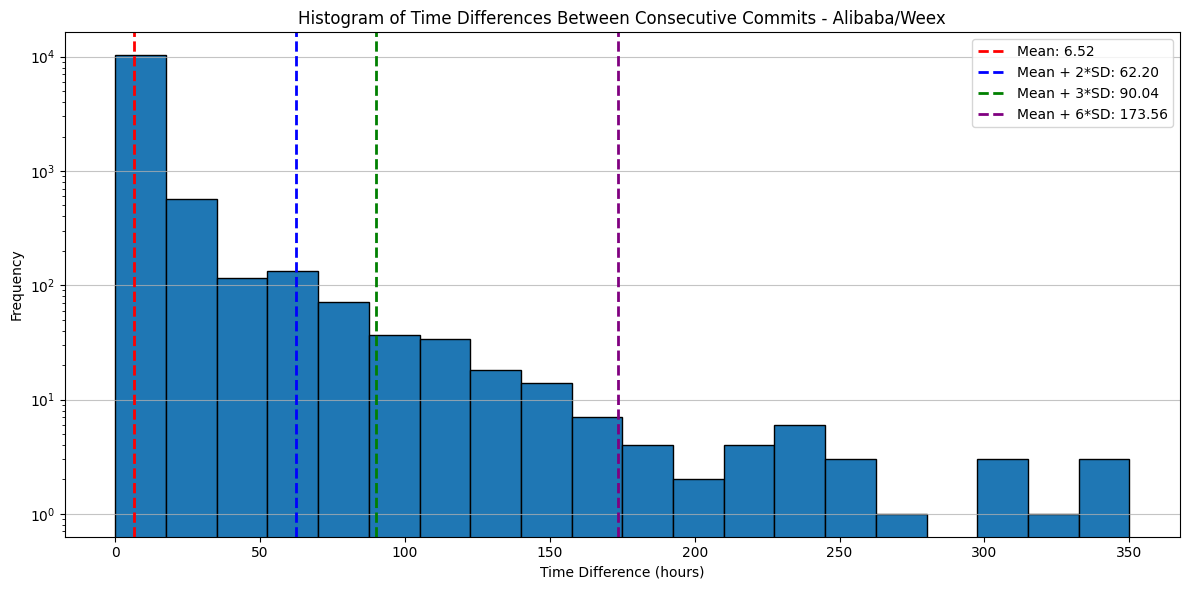

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'repo' is your DataFrame with commit information
repo['time_diff'] = repo['date'].diff()
repo['time_diff'] = repo['time_diff'].fillna(pd.to_timedelta(0))
repo['time_diff_hours'] = repo['time_diff'].dt.total_seconds() / 3600

 
plt.figure(figsize=(12, 6))
plt.hist(repo['time_diff_hours'], bins=20, edgecolor='black', range=(0, 350))  
plt.title('Histogram of Time Differences Between Consecutive Commits - Alibaba/Weex')
plt.xlabel('Time Difference (hours)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

 
plt.yscale('log')

# Add mean line
mean_value = repo['time_diff_hours'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

# Add second standard deviation (SD) line
std_value = repo['time_diff_hours'].std()
second_sd_line = mean_value + 2 * std_value
plt.axvline(second_sd_line, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 2*SD: {second_sd_line:.2f}')

# Add third standard deviation (SD) line
second_sd_line = mean_value + 3 * std_value
plt.axvline(second_sd_line, color='green', linestyle='dashed', linewidth=2, label=f'Mean + 3*SD: {second_sd_line:.2f}')


# Add third standard deviation (SD) line
second_sd_line = mean_value + 6 * std_value
plt.axvline(second_sd_line, color='purple', linestyle='dashed', linewidth=2, label=f'Mean + 6*SD: {second_sd_line:.2f}')

plt.legend()  

plt.tight_layout()
plt.show()


In [47]:
repo

,url,repo,author,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple,time_diff,time_diff_hours,code_churn
date,,,,,,,,,,,,,
2016-03-11 10:18:12+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,lvscar,203,0,203,Initial commit,2,0,"[(LICENSE, added, 201, 0, 201, https://github....",NaT,0.000000,203
2016-04-12 15:21:18+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,617,8351,-7734,+ [all] init,1046,0,"[(CONTRIBUTING.md, modified, 0, 0, 0, https://...",32 days 05:03:06,773.051667,8968
2016-04-12 15:21:18+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,142902,5,142897,+ [all] init,1054,1,"[(.gitignore, added, 23, 0, 23, https://github...",0 days 00:00:00,0.000000,142907
2016-04-12 15:22:31+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,30,6,24,+ [doc] contributing doc,2,0,"[(CONTRIBUTING.md, added, 28, 0, 28, https://g...",0 days 00:01:13,0.020278,36
2016-04-12 16:00:06+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,32,16,16,* [doc] commit & branch format,2,0,"[(CONTRIBUTING.md, modified, 31, 11, 42, https...",0 days 00:37:35,0.626389,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-07 13:19:18+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,katherine95s,2,1,1,fix:修复OnReceivedResult CallbackId (#3313) * [...,1,0,[(weex_core/Source/android/bridge/script_bridg...,63 days 06:04:41,1518.078056,3
2022-09-28 03:42:59+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,yuditxj,8,0,8,[ios]fix maxlength issues (#3312),1,0,[(ios/sdk/WeexSDK/Sources/Component/WXEditComp...,20 days 14:23:41,494.394722,8
2022-09-28 03:44:41+00:00,https://api.github.com/repos/alibaba/weex/comm...,weex,yuditxj,2,0,2,[ios]fix date|time reset issues (#3311),1,0,[(ios/sdk/WeexSDK/Sources/Component/WXEditComp...,0 days 00:01:42,0.028333,2


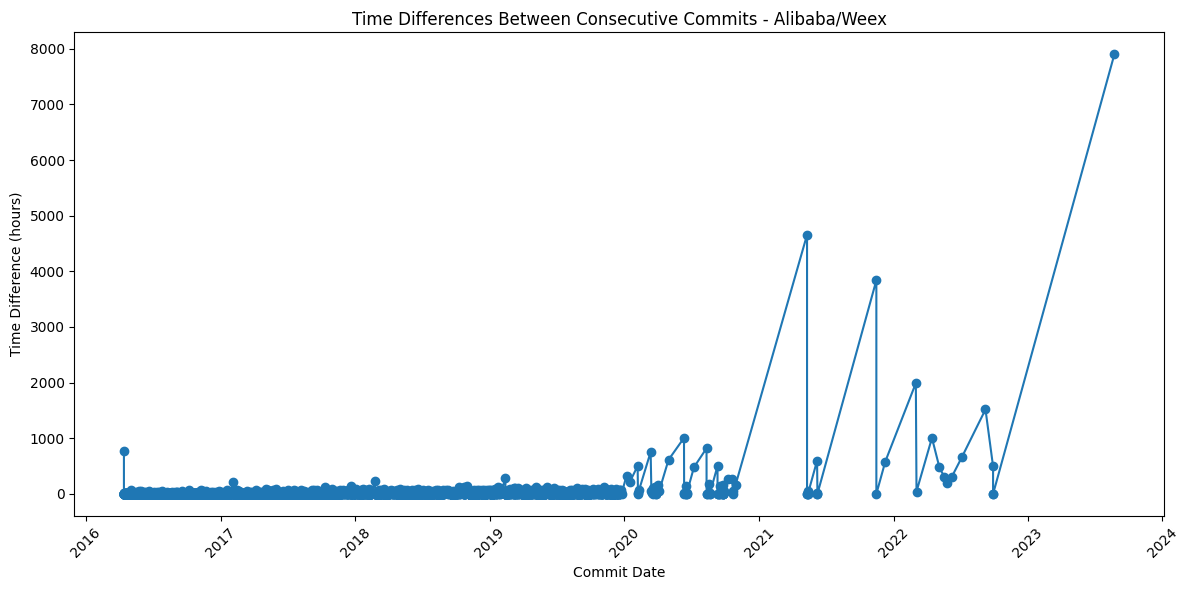

In [17]:
import pandas as pd
import matplotlib.pyplot as plt



# Calculate time differences between consecutive commits
repo['time_diff'] = repo['date'].diff()

 
plot_data = pd.DataFrame({
    'commit_date': repo['date'],
    'time_diff': repo['time_diff']
})

 
plt.figure(figsize=(12, 6))
plt.plot(plot_data['commit_date'], plot_data['time_diff'].dt.total_seconds() / 3600, marker='o', linestyle='-')
plt.title('Time Differences Between Consecutive Commits - Alibaba/Weex')
plt.xlabel('Commit Date')
plt.ylabel('Time Difference (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\ethan\AppData\Local\Temp\ipykernel_32512\1343960593.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_repo['time_diff'] = filtered_repo['date'].diff()


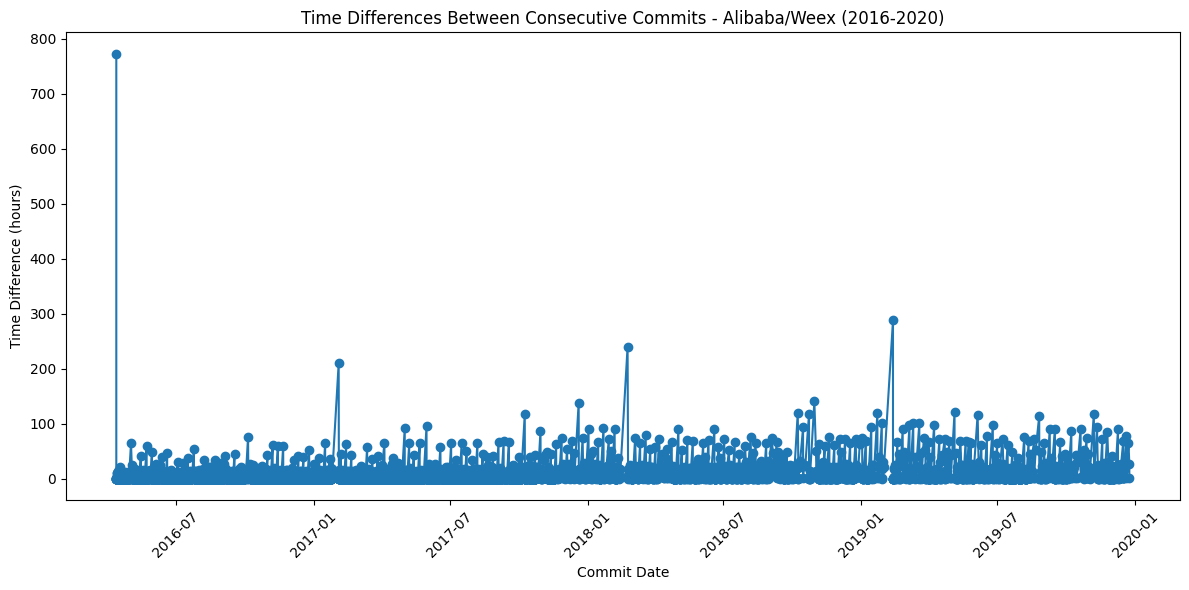

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

 
filtered_repo = repo[(repo['date'] >= '2016-01-01') & (repo['date'] <= '2020-01-1')]

# Calculate time differences between consecutive commits
filtered_repo['time_diff'] = filtered_repo['date'].diff()

 
plot_data = pd.DataFrame({
    'commit_date': filtered_repo['date'],
    'time_diff': filtered_repo['time_diff']
})

 
plt.figure(figsize=(12, 6))
plt.plot(plot_data['commit_date'], plot_data['time_diff'].dt.total_seconds() / 3600, marker='o', linestyle='-')
plt.title('Time Differences Between Consecutive Commits - Alibaba/Weex (2016-2020)')
plt.xlabel('Commit Date')
plt.ylabel('Time Difference (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Code latency 

In [19]:

# Calculate statistics for code review latency
average_latency = repo['time_diff_hours'].mean()
median_latency = repo['time_diff_hours'].median()
max_latency = repo['time_diff_hours'].max()

print(f"Average Code  Latency: {average_latency:.2f} hours")
print(f"Median Code  Latency: {median_latency:.2f} hours")
print(f"Maximum Code  Latency: {max_latency:.2f} hours")

Average Code  Latency: 5.42 hours
Median Code  Latency: 0.24 hours
Maximum Code  Latency: 7900.86 hours


#### Code Churn

In [33]:
repo['code_churn'] = repo['totalAdditions'] + repo['totalDeletions']


# Set the date column as the index
repo.set_index('date', inplace=True)

# Resample and sum churn over your chosen time interval, e.g., weekly
weekly_churn = repo['code_churn'].resample('W').sum()


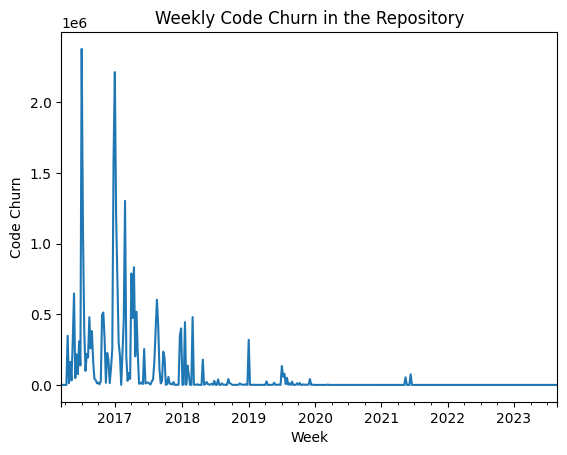

In [34]:
import matplotlib.pyplot as plt

weekly_churn.plot()
plt.title('Weekly Code Churn in the Repository')
plt.xlabel('Week')
plt.ylabel('Code Churn')
plt.show()


In [35]:
# Weekly Churn
weekly_churn = repo['code_churn'].resample('W').sum()

# Monthly Churn
monthly_churn = repo['code_churn'].resample('M').sum()

# Quarterly Churn
quarterly_churn = repo['code_churn'].resample('Q').sum()


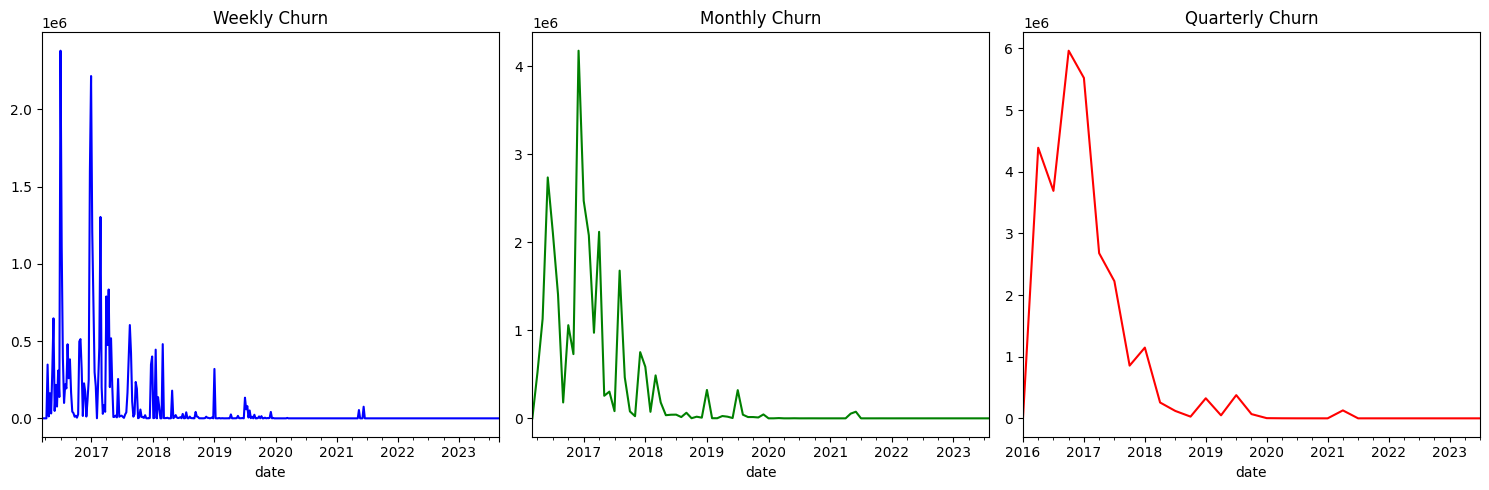

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plotting Weekly Churn
plt.subplot(1, 3, 1)
weekly_churn.plot(title='Weekly Churn', color='blue')

# Plotting Monthly Churn
plt.subplot(1, 3, 2)
monthly_churn.plot(title='Monthly Churn', color='green')

# Plotting Quarterly Churn
plt.subplot(1, 3, 3)
quarterly_churn.plot(title='Quarterly Churn', color='red')

plt.tight_layout()
plt.show()


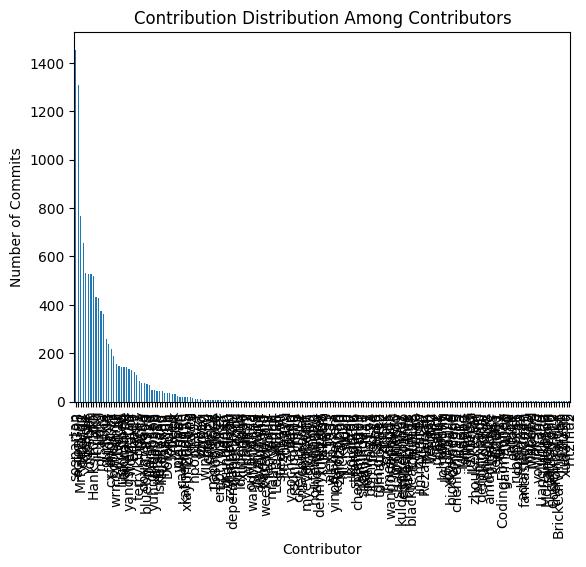

In [43]:
commit_counts = repo['author'].value_counts()
commit_counts.plot(kind='bar')
plt.title('Contribution Distribution Among Contributors')
plt.xlabel('Contributor')
plt.ylabel('Number of Commits')
plt.show()


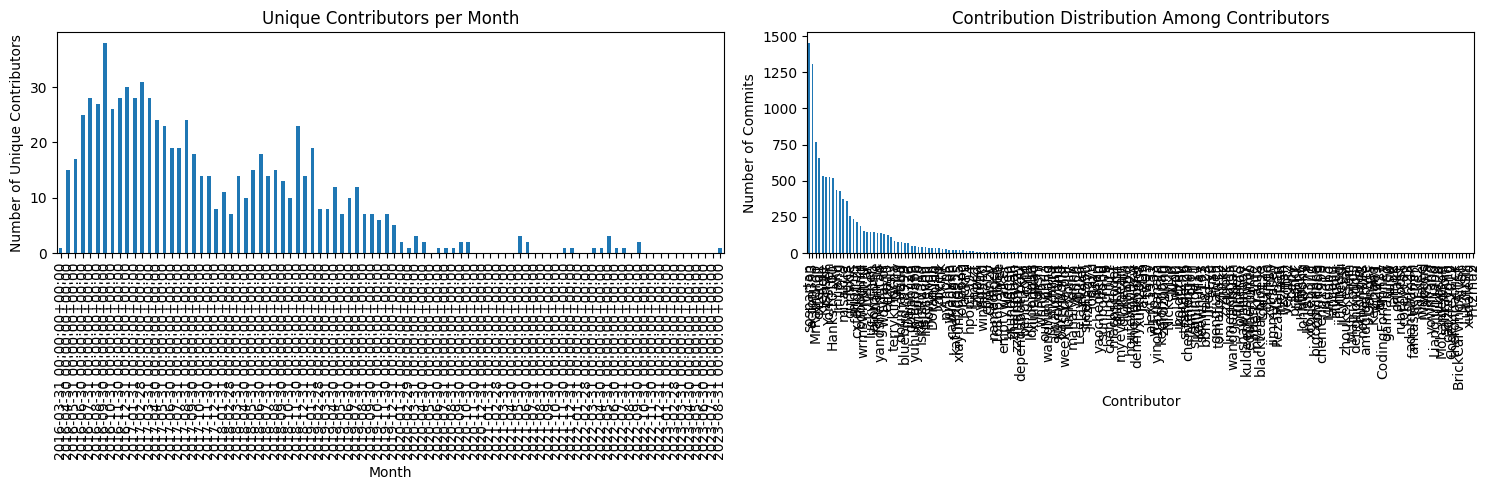

In [44]:
plt.figure(figsize=(15, 5))

# Plotting unique contributors over time
plt.subplot(1, 2, 1)
monthly_contributors.plot(kind='bar')
plt.title('Unique Contributors per Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Contributors')

# Plotting contribution distribution
plt.subplot(1, 2, 2)
commit_counts.plot(kind='bar')
plt.title('Contribution Distribution Among Contributors')
plt.xlabel('Contributor')
plt.ylabel('Number of Commits')

plt.tight_layout()
plt.show()


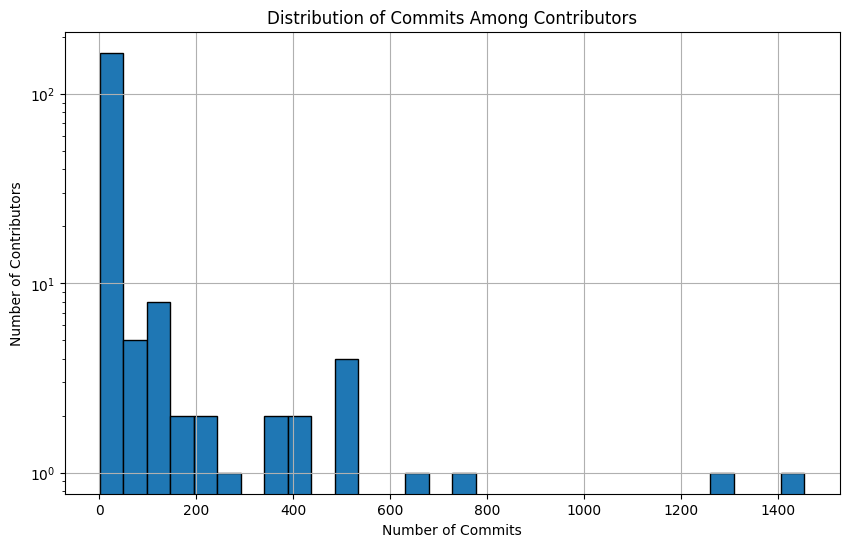

In [39]:
# Set the date as the index
repo.set_index('date', inplace=True)

# Count unique contributors monthly
monthly_contributors = repo.groupby(pd.Grouper(freq='M'))['author'].nunique()

#### time series

In [59]:
import pandas as pd



# Resample the data to a regular time interval (e.g., daily)
# Use the count of commits per day as the value to forecast
daily_commits = repo.resample('D').size()


In [60]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
result = adfuller(daily_commits.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.5538253163260896
p-value: 0.10292101766679645


In [88]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit the ARIMA model
# Experiment with different parameters (p, d, q) as needed
model = ARIMA(daily_commits, order=(2, 2, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2722
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -9384.339
Date:                Tue, 23 Jan 2024   AIC                          18776.678
Time:                        14:50:50   BIC                          18800.312
Sample:                    03-11-2016   HQIC                         18785.222
                         - 08-23-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1437      0.010    -15.051      0.000      -0.162      -0.125
ar.L2         -0.2614      0.009    -29.422      0.000      -0.279      -0.244
ma.L1         -1.0000      0.658     -1.519      0.1

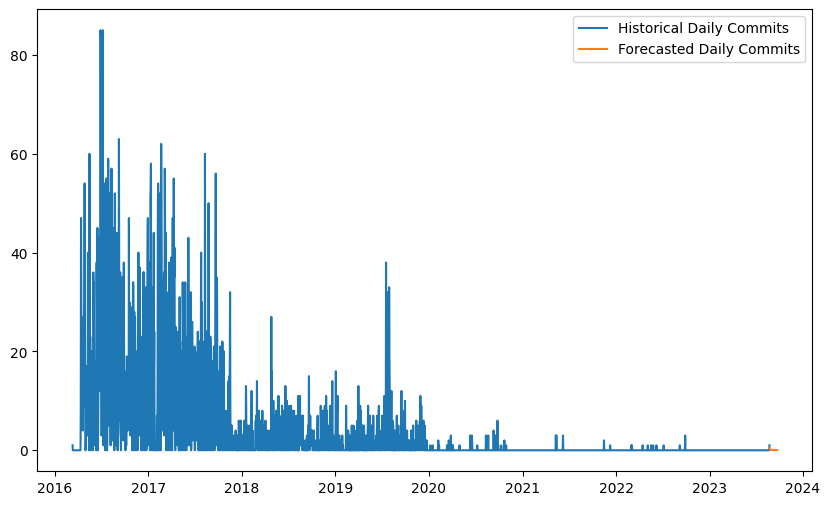

In [75]:
# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)

plt.figure(figsize=(10, 6))
plt.plot(daily_commits, label='Historical Daily Commits')
plt.plot(forecast, label='Forecasted Daily Commits')
plt.legend()
plt.show()


In [76]:
forecast

2023-08-24 00:00:00+00:00    0.459818
2023-08-25 00:00:00+00:00    0.229814
2023-08-26 00:00:00+00:00    0.131881
2023-08-27 00:00:00+00:00    0.090182
2023-08-28 00:00:00+00:00    0.072426
2023-08-29 00:00:00+00:00    0.064867
2023-08-30 00:00:00+00:00    0.061648
2023-08-31 00:00:00+00:00    0.060277
2023-09-01 00:00:00+00:00    0.059693
2023-09-02 00:00:00+00:00    0.059445
2023-09-03 00:00:00+00:00    0.059339
2023-09-04 00:00:00+00:00    0.059294
2023-09-05 00:00:00+00:00    0.059275
2023-09-06 00:00:00+00:00    0.059267
2023-09-07 00:00:00+00:00    0.059263
2023-09-08 00:00:00+00:00    0.059262
2023-09-09 00:00:00+00:00    0.059261
2023-09-10 00:00:00+00:00    0.059261
2023-09-11 00:00:00+00:00    0.059261
2023-09-12 00:00:00+00:00    0.059261
2023-09-13 00:00:00+00:00    0.059261
2023-09-14 00:00:00+00:00    0.059261
2023-09-15 00:00:00+00:00    0.059261
2023-09-16 00:00:00+00:00    0.059261
2023-09-17 00:00:00+00:00    0.059261
2023-09-18 00:00:00+00:00    0.059261
2023-09-19 0

In [ ]:
import pandas as pd

# Convert the 'fileTuple' column from a list to a string
repo['fileTuple'] = repo['fileTuple'].apply(str)

# Parse the 'fileTuple' column to extract file information using ast.literal_eval
import ast
repo['fileTuple'] = repo['fileTuple'].apply(ast.literal_eval)

# Create a new DataFrame to store file-level information
file_df = pd.DataFrame()

# Iterate through each row of the original DataFrame
for index, row in repo.iterrows():
    commit_files = row['fileTuple']
    for file_info in commit_files:
        file_dict = {
            'url': row['url'],
            'file_name': file_info[0],
            'status': file_info[1],
            'additions': file_info[2],
            'deletions': file_info[3],
            'changes': file_info[4],
            'raw_url': file_info[5],
            'contents_url': file_info[6]
        }
        # Use concat to append rows to the DataFrame
        file_df = pd.concat([file_df, pd.DataFrame([file_dict])], ignore_index=True)

# Group the file DataFrame by 'file_name' and sum the changes
file_changes = file_df.groupby('file_name')['changes'].sum()

# Sort the files based on the total changes in descending order
sorted_files = file_changes.sort_values(ascending=False)

# Display the files with the most commit changes
print(sorted_files.head())


In [ ]:
file_changes

file_name
.DS_Store                                                   0
.babelrc                                                    0
.eslintignore                                             183
.eslintrc                                                2111
.flowconfig                                               328
                                                        ...  
weex_core/test/third_party/googletest/library.json         59
weex_core/test/third_party/googletest/platformio.ini       31
weex_core/tools/cpp-style-check.sh                        174
weex_core/tools/cpplint.py                              12410
weex_core/trace.sh                                          2
Name: changes, Length: 10429, dtype: int64

In [ ]:
sorted_files

file_name
package-lock.json                                                                                           15238
packages/weex-legacy-framework/index.js                                                                     11554
playground/package-lock.json                                                                                 5032
test/js-framework/unit/default/vm/vm.js                                                                      3950
playground/ios/bundlejs/about.weex.js                                                                        3309
                                                                                                            ...  
playground/android/playground/src/androidTest/java/org/apache/weex/uitest/uitest/TC_Animation/.gitignore        0
playground/ios/WeexDemo.xcworkspace/xcuserdata/jianhan.xcuserdatad/UserInterfaceState.xcuserstate               0
playground/ios/WeexDemo.xcworkspace/xcuserdata/wangrenmin.xcuserdatad/UserInte

In [26]:

merged_df = pd.merge(file_df, repo[['url', 'date']], on='url')

# Display the resulting DataFrame with file name, net code change, and commit date
result_df = merged_df[['file_name', 'changes', 'date']]

# Sort the resulting DataFrame by the 'changes' column in descending order
result_df = result_df.sort_values(by='changes', ascending=False)

result_df

,file_name,changes,date
2094,website/js/vendor/jquery.js,9210,2016-04-12 15:21:18+00:00
498,android/sdk/assets/main.js,7806,2016-04-12 15:21:18+00:00
4607,android/sdk/assets/main.js,7806,2016-04-26 06:04:51+00:00
2895,android/sdk/assets/main.js,7798,2016-04-14 02:42:37+00:00
2867,android/sdk/assets/main.js,7798,2016-04-13 16:41:46+00:00
...,...,...,...
280,android/playground/app/src/main/java_zxing/com...,0,2016-04-12 15:21:18+00:00
279,android/playground/app/src/main/java_zxing/com...,0,2016-04-12 15:21:18+00:00
278,android/playground/app/src/main/java_zxing/com...,0,2016-04-12 15:21:18+00:00
277,android/playground/app/src/main/java_zxing/com...,0,2016-04-12 15:21:18+00:00


In [ ]:
# Assuming your DataFrame is named sorted_result_df
file_occurrences = sorted_result_df[sorted_result_df['file_name'] == 'packages/weex-legacy-framework/index.js']
 
print(file_occurrences)


### Numerical df

In [ ]:
repo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12044 entries, 2023-08-23 10:57:34+00:00 to 2016-03-11 10:18:12+00:00
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              12044 non-null  object
 1   repo             12044 non-null  object
 2   author           11256 non-null  object
 3   totalAdditions   12044 non-null  int64 
 4   totalDeletions   12044 non-null  int64 
 5   net_code_change  12044 non-null  int64 
 6   message          12044 non-null  object
 7   numFiles         12044 non-null  int64 
 8   numComments      12044 non-null  int64 
 9   fileTuple        12044 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.0+ MB


In [ ]:
num_df = repo
# Creating a new DataFrame with only numerical features
num_df = ['author','totalAdditions', 'totalDeletions', 'numFiles', 'numComments']

num_df = repo[num_df]


In [28]:
repo.head(3)

,url,repo,author,date,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple,time_diff,time_diff_hours
12043,https://api.github.com/repos/alibaba/weex/comm...,weex,lvscar,2016-03-11 10:18:12+00:00,203,0,203,Initial commit,2,0,"[(LICENSE, added, 201, 0, 201, https://github....",NaT,0.000000
11892,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 15:21:18+00:00,617,8351,-7734,+ [all] init,1046,0,"[(CONTRIBUTING.md, modified, 0, 0, 0, https://...",32 days 05:03:06,773.051667
12042,https://api.github.com/repos/alibaba/weex/comm...,weex,luics,2016-04-12 15:21:18+00:00,142902,5,142897,+ [all] init,1054,1,"[(.gitignore, added, 23, 0, 23, https://github...",0 days 00:00:00,0.000000


#### OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

# Reshape the 'artists' column
artists_column = num_df['author'].values.reshape(-1, 1)


one_hot_encoded_artists = one_hot_encoder.fit_transform(artists_column)

num_df['author'] = np.argmax(one_hot_encoded_artists, axis=1)
num_df['net_code_change'] = num_df['totalAdditions'] - num_df['totalDeletions']


C:\Users\ethan\AppData\Local\Temp\ipykernel_1652\1322002274.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df['author'] = np.argmax(one_hot_encoded_artists, axis=1)
C:\Users\ethan\AppData\Local\Temp\ipykernel_1652\1322002274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df['net_code_change'] = num_df['totalAdditions'] - num_df['totalDeletions']


In [ ]:
num_df.head()

,author,totalAdditions,totalDeletions,numFiles,numComments,net_code_change
date,,,,,,
2023-08-23 10:57:34+00:00,183,2,1,1,0,1
2022-09-28 06:06:08+00:00,183,7,3,1,0,4
2022-09-28 03:44:41+00:00,183,2,0,1,0,2
2022-09-28 03:42:59+00:00,183,8,0,1,0,8
2022-09-07 13:19:18+00:00,99,2,1,1,0,1


In [ ]:
num_df.isnull().sum()

author             0
totalAdditions     0
totalDeletions     0
numFiles           0
numComments        0
net_code_change    0
dtype: int64

## Graph Deep Learning 

In [29]:
ali_repo = ali_repo.rename(columns={'fileTuples<fileName. status. additions. deletions. changes. raw_url. contents_url>': 'fileTuple'})
ali_repo['net_code_change'] = ali_repo['totalAdditions'] - ali_repo['totalDeletions']


In [24]:
import dgl
import torch


ali_repo['commit_id'] = ali_repo['sha'].astype('category').cat.codes

# Create a dictionary to map commit IDs to their row indices
commit_id_to_index = {commit_id: index for index, commit_id in enumerate(ali_repo['commit_id'])}


# We will create edges between consecutive commits
src = [commit_id_to_index[id] for id in ali_repo['commit_id'][:-1]]
dst = [commit_id_to_index[id] for id in ali_repo['commit_id'][1:]]

# Create the DGL Graph
g = dgl.graph((src, dst))


# For simplicity, we ignore other potential features for now
features = torch.tensor(ali_repo[['net_code_change',  'numFiles', 'numComments']].values, dtype=torch.float32)
g.ndata['features'] = features

g, features.shape


(Graph(num_nodes=12044, num_edges=12043,
       ndata_schemes={'features': Scheme(shape=(3,), dtype=torch.float32)}
       edata_schemes={}),
 torch.Size([12044, 3]))

In [ ]:
pip install dgl

In [ ]:
import dgl
import torch
import pandas as pd
from collections import defaultdict

# Load the data
df = ali_repo[:50]

df['fileTuples'] = df['fileTuples'].apply(eval)

# Initialize a dictionary to keep track of files and the commits that modified them
file_to_commits = defaultdict(list)

# Populate the dictionary
for index, row in df.iterrows():
    for file_tuple in row['fileTuple']:
        filename = file_tuple[0]  # Assuming the first element of the tuple is the filename
        file_to_commits[filename].append(row['commit_id'])

# Create edges based on shared files
edges_src = []
edges_dst = []

for commits in file_to_commits.values():
    for i in range(len(commits)):
        for j in range(i + 1, len(commits)):
            edges_src.append(commits[i])
            edges_dst.append(commits[j])

# Convert edges to tensor
edge_tensor_src = torch.tensor(edges_src, dtype=torch.int64)
edge_tensor_dst = torch.tensor(edges_dst, dtype=torch.int64)


g = dgl.graph((edge_tensor_src, edge_tensor_dst))


features = torch.tensor(df[['totalAdditions', 'totalDeletions', 'net_code_change']].values, dtype=torch.float32)
g.ndata['features'] = features




In [ ]:
g, features.shape

C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_20152\2539844134.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(nx_graph.nodes(), sample_size)


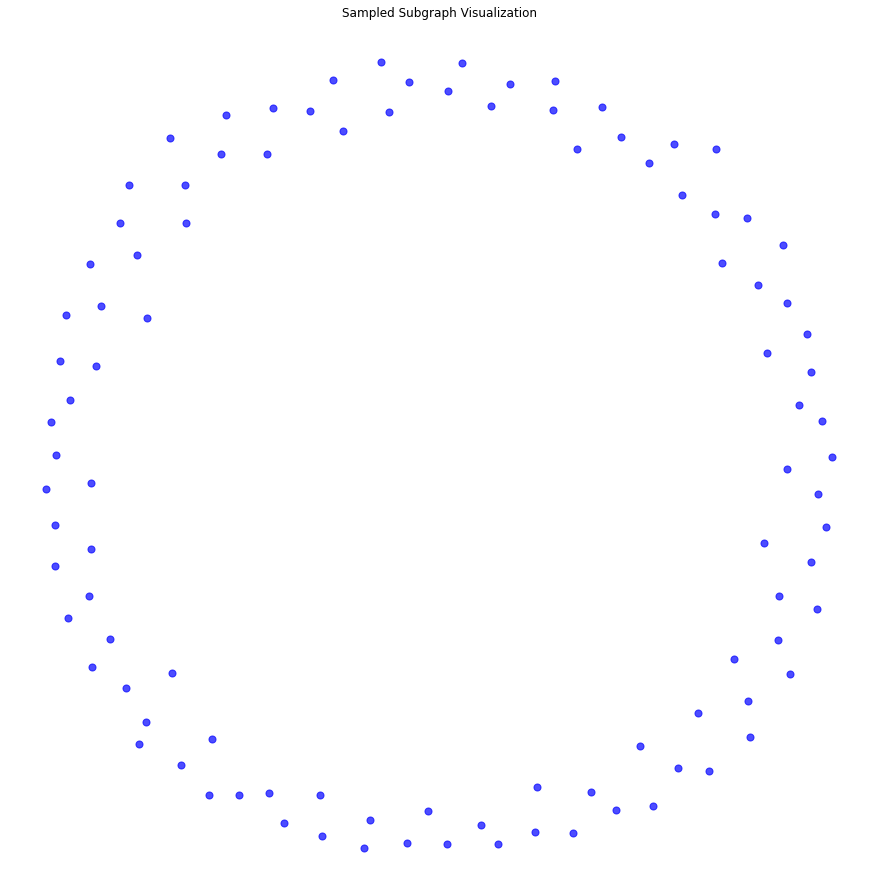

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Convert DGL graph to NetworkX for visualization
nx_graph = g.to_networkx().to_undirected()

# Since the graph is large, we'll take a random sample of nodes for visualization
sample_size = 100  # number of nodes in the sample
sampled_nodes = random.sample(nx_graph.nodes(), sample_size)
subgraph = nx_graph.subgraph(sampled_nodes)

# Visualize the subgraph
plt.figure(figsize=(12, 12))
nx.draw(subgraph, with_labels=False, node_size=50, node_color="blue", alpha=0.7, edge_color="gray")
plt.title("Sampled Subgraph Visualization")
plt.show()


In [ ]:
import dgl
import torch

# Create a graph with 3 nodes and 4 edges
u = torch.tensor([0, 0, 0, 1])  # Source nodes
v = torch.tensor([1, 2, 3, 3])  # Destination nodes
g = dgl.graph((u, v))


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
# Add node features
g.ndata['feature'] = torch.randn(3, 5)  # 3 nodes with 5 features each

# Add edge features
g.edata['weight'] = torch.randn(4, 2)  # 4 edges with 2 features each


In [ ]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, h_feats)
        self.conv2 = dglnn.GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = F.relu(self.conv1(g, in_feat))
        h = self.conv2(g, h)
        return h
